# Exploring Hugging Face Model and Dataset APIs With `xaitk-saliency` Integration

This example demonstrates loading a subset of a dataset located on Hugging Face's hub and then using that data within an object detection "pipeline" to get predictions from a model hosted on Hugging Face's hub. This notebook will also explore one method of integrating Hugging Face and `xaitk-saliency` to generate saliency maps for model predictions.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Imports](#imports)
* [Inspect and Load Dataset](#inspect-and-load-dataset)
* [Using Hugging Face's Pipeline for Model Predictions](#hugging-face-pipeline-predictions)
  * [Pipeline Setup](#pipeline-setup)
  * [Predicting With the Pipeline Directly](#predicting-with-pipeline-directly)
  * [Visualizing Pipeline Predictions](#visualizing-pipeline-predictions)
* [Hugging Face/XAITK Integration](#hugging-face-xaitk-integration)
  * [`DetectImageObjects` Implementation](#detect-image-objects-implementation)
  * [Instantiate Detector Object](#instantiate-detector-object)
  * [Get Predictions From the Detector Object](#predictions-from-detector-object)
  * [Visualize Predictions](#visualize-predictions)
  * [Generate Saliency Maps with `xaitk-saliency`](#generate-saliency-maps-with-xaitk-saliency)
    * [Prepare Inputs](#prepare-inputs)
    * [Saliency Generation Object](#saliency-generation-object)
    * [Saliency Map Generation](#saliency-map-generation)
    * [Saliency Map Visualization](#saliency-map-visualization)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/xaitk-jatic/blob/main/docs/examples/huggingface/xaitk-huggingface.ipynb)

## Environment Setup <a name="environment-setup"></a>

Here we install `datasets` and `transformers` from Hugging Face, as well as matplotlib for some quick visualization and `xaitk-saliency` for saliency map generation.

The model we will be using for this example utilizes PyTorch Image Models (`timm`) so we will also install that now. Note Python 3.7+ is required for PyTorch.

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/xaitk-jatic/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

**Running huggingface in Colab requires an API key. Log in to https://huggingface.co/, generate an access token, then add that token to Colab using the key icon in the left menu.**

In [1]:
import sys  # noqa:F401

!{sys.executable} -m pip install -qU pip
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -qU datasets fsspec huggingface_hub
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing timm...")
!{sys.executable} -m pip install -q timm
print("Done!")

Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing matplotlib...
Installing xaitk-saliency...
Installing timm...
Done!


## Imports <a name="imports"></a>

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt  # type: ignore
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle  # type: ignore

# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

import time
from collections.abc import Hashable, Iterable
from typing import Any, cast

import numpy as np
from datasets import load_dataset, load_dataset_builder  # type: ignore
from PIL import Image

# xaitk-saliency/smqtk imports
from smqtk_detection.interfaces.detect_image_objects import DetectImageObjects
from smqtk_image_io.bbox import AxisAlignedBoundingBox

# Hugging Face imports
from transformers import AutoFeatureExtractor, AutoModelForObjectDetection, PreTrainedModel, pipeline  # type: ignore
from typing_extensions import override
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

## Inspect and Load Dataset <a name="inspect-and-load-dataset"></a>

Before loading the dataset, we can inspect it using `load_dataset_builder`. We'll be using a dataset of images from chapbooks held by the National Library of Scotland, the dataset card can be found [here](https://huggingface.co/datasets/biglam/nls_chapbook_illustrations "biglam/nls_chapbook_illustrations Dataset Card").

The first argument to the load dataset builder specifies the dataset we're interested in while the second specifies a subset of that particular dataset.

In [3]:
ds_builder = load_dataset_builder("biglam/nls_chapbook_illustrations", "illustration-detection", trust_remote_code=True)

In [4]:
# Inspect dataset description
ds_builder.info.description

'This dataset comprises of images from chapbooks held by the National Library of Scotland and digitised and published as its Chapbooks Printed in Scotland dataset'

In [5]:
# Inspect dataset features
ds_builder.info.features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': [{'category_id': ClassLabel(names=['early_printed_illustration'], id=None),
   'image_id': Value(dtype='string', id=None),
   'id': Value(dtype='int64', id=None),
   'area': Value(dtype='int64', id=None),
   'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None),
   'segmentation': [[Value(dtype='float32', id=None)]],
   'iscrowd': Value(dtype='bool', id=None)}]}

We can then actually load the dataset, with the same arguments as before. Hugging Face will cache downloaded information to avoid unnecessarily downloading duplicate data.

In [ ]:
ds = load_dataset("biglam/nls_chapbook_illustrations", "illustration-detection")

In [ ]:
# Inspect dataset structure
ds  # type: ignore

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 7258
    })
})

We can see from inspecting the dataset (or looking at the dataset card) that this dataset only has a single split, `train`.

In [ ]:
ds_train = ds["train"]  # type: ignore

In [ ]:
# Inspect example datum structure
ds_train[0]

{'image_id': 4,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x1080>,
 'width': 600,
 'height': 1080,
 'objects': [{'category_id': 0,
   'image_id': '4',
   'id': 1,
   'area': 110901,
   'bbox': [34.529998779296875,
    556.8300170898438,
    401.44000244140625,
    276.260009765625],
   'segmentation': [[34.529998779296875,
     556.8300170898438,
     435.9700012207031,
     556.8300170898438,
     435.9700012207031,
     833.0900268554688,
     34.529998779296875,
     833.0900268554688]],
   'iscrowd': False}]}

In [ ]:
# For this example, shuffle the dataset to look at random sampling of the data.
ds_train_shuffle = ds_train.shuffle(seed=0)  # type: ignore

sample_idxs = [0, 2, 3]
num_predictions = len(sample_idxs)
ds_samples = [ds_train_shuffle[idx] for idx in sample_idxs]

In [ ]:
# Create a mapping of labels/ids
id2label = dict(enumerate(ds_train.features["objects"][0]["category_id"].names))  # type: ignore
label_to_id = {v: k for k, v in id2label.items()}

## Using Hugging Face's Pipeline for Model Predictions <a name="hugging-face-pipeline-predictions"></a>

Hugging Face gives users "pipeline" for rapid predictions using pre-trained models which we will be utilizing.

### Pipeline Setup <a name="pipeline-setup"></a>

`Auto` classes serve as generic classes that will be instantiated as one of the derived classes of the library. `Tokenizers` or, in the case of vision-based models, `FeatureExtractors` are used to get the data in the format the model expects. We're using `AutoModelForObjectDetection` which is specifically for models with an object detection head.

For this example, we will be using `biglam/detr-resnet-50_fine_tuned_nls_chapbooks` which is a version of the `facebook/detr-resnet50` model fine-tuned for the dataset we've loaded. The model card for this model can be found [here](https://huggingface.co/biglam/detr-resnet-50_fine_tuned_nls_chapbooks "biglam/detr-resnet-50_fine_tuned_nls_chapbooks Model Card").

In [ ]:
extractor = AutoFeatureExtractor.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")
model = AutoModelForObjectDetection.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")

/home/local/KHQ/emily.veenhuis/Documents/nrtk/venv/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at biglam/detr-resnet-50_fine_tuned_nls_chapbooks were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model)

Once we have our model and feature extractor, we can set up our pipeline.

In [ ]:
obj_detection_pipe = pipeline("object-detection", model=model, feature_extractor=extractor)

### Predicting With the Pipeline Directly <a name="predicting-with-pipeline-directly"></a>

Simply provide data to this pipeline to get model predictions.

In [ ]:
pipeline_dets = obj_detection_pipe([d["image"] for d in ds_samples])

# Inspect predictions
pipeline_dets  # type: ignore

[[{'score': 0.9966813921928406,
   'label': 'early_printed_illustration',
   'box': {'xmin': 40, 'ymin': 571, 'xmax': 359, 'ymax': 824}}],
 [{'score': 0.9962982535362244,
   'label': 'early_printed_illustration',
   'box': {'xmin': 71, 'ymin': 18, 'xmax': 439, 'ymax': 368}}],
 [{'score': 0.9955165982246399,
   'label': 'early_printed_illustration',
   'box': {'xmin': 30, 'ymin': 562, 'xmax': 482, 'ymax': 931}}]]

### Visualizing Pipeline Predictions <a name="visualizing-pipeline-predictions"></a>

We can write some `matplotlib` code to visualize these predictions.

In [ ]:
def show_pipeline_dets(
    ax: Axes,
    dets: list[dict[str, Any]],
    thresh: float = 0.5,
    show_labels: bool = False,
) -> None:
    """
    Displays bounding boxes and optional class labels with scores for object detections on a Matplotlib axis.

    Args:
        ax (Axes): The Matplotlib axis on which to draw the detections.
        dets (List[Dict[str, float]]): A list of detections. Each detection is a tuple:
            - The first element is a bounding box object represented as a dictionary with keys:
                - "xmin" (float): Minimum x-coordinate.
                - "xmax" (float): Maximum x-coordinate.
                - "ymin" (float): Minimum y-coordinate.
                - "ymax" (float): Maximum y-coordinate.
            - The second element is a dictionary with:
                - "label" (str): Class label for the detection.
                - "score" (float): Confidence score for the detection.
        thresh (float, optional): The confidence threshold for displaying a detection. Defaults to 0.5.
        show_labels (bool, optional): Whether to display the class label and confidence score. Defaults to False.

    Returns:
        None: The function modifies the given Matplotlib axis directly.
    """
    for _, det in enumerate(dets):
        conf = det["score"]
        if conf >= thresh:
            box = det["box"]
            xmin, xmax, ymin, ymax = box["xmin"], box["xmax"], box["ymin"], box["ymax"]
            label = det["label"]

            ax.add_patch(
                Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor="r", facecolor="none"),
            )

            if show_labels:
                text = f"{label}: {conf:0.2f}"
                ax.text(xmin, ymin, text, color="b", fontsize=8)

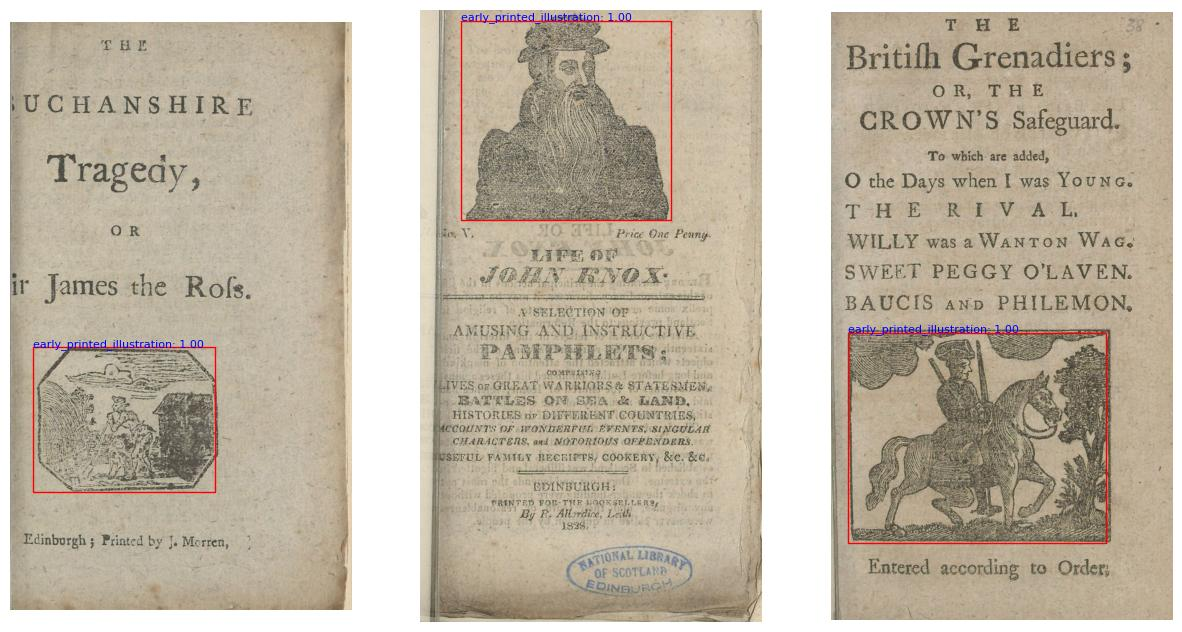

In [ ]:
fig, axs = plt.subplots(1, num_predictions, figsize=(15, 15))
if num_predictions == 1:
    axs = [axs]

for idx, ax in enumerate(axs):
    ax.imshow(ds_samples[idx]["image"])  # type: ignore
    ax.axis("off")  # type: ignore
    show_pipeline_dets(ax, pipeline_dets[idx], thresh=0.4, show_labels=True)  # type: ignore

## Hugging Face/XAITK Integration <a name="hugging-face-xaitk-integration"></a>

### `DetectImageObjects` Implementation <a name="detect-image-objects-implementation"></a>

To use the selected model with the `GenerateObjectDetectorBlackboxSaliency` interface, we need to create an implementation of `DetectImageObjects` that wraps the underlying model. The core method that requires implementation is `detect_objects()` which takes images and returns predictions for each image in the formated defined by the interface.

In [ ]:
class HuggingFaceObjectDetector(DetectImageObjects):
    """
    A wrapper for a Hugging Face object detection pipeline that adheres to the DetectImageObjects interface.

    Attributes:
        model: The pre-trained Hugging Face model for object detection.
        extractor: The Hugging Face feature extractor for preprocessing images.
        obj_detection_pipe: The Hugging Face object detection pipeline.
    """

    def __init__(
        self,
        model: PreTrainedModel,
        feature_extractor: AutoFeatureExtractor,
    ) -> None:
        """
        Initializes the HuggingFaceObjectDetector with a pre-trained model and feature extractor.

        Args:
            model: The pre-trained Hugging Face object detection model.
            feature_extractor: The Hugging Face feature extractor for preprocessing images.
        """
        self.model = model
        self.extractor = feature_extractor
        self.obj_detection_pipe = pipeline("object-detection", model=self.model, feature_extractor=self.extractor)

    @override
    def detect_objects(
        self,
        img_iter: Iterable[np.ndarray],
    ) -> Iterable[Iterable[tuple[AxisAlignedBoundingBox, dict[Hashable, float]]]]:
        preds = []

        for img in list(img_iter):
            # Hugging Face expects images to be in PIL format
            img_pil = Image.fromarray(img)
            detections = cast(list[dict[str, Any]], self.obj_detection_pipe(img_pil))
            preds.append(pred_to_list(detections))

        return preds

    # requried by interface
    @override
    def get_config(self) -> dict[str, Any]:
        return {}


def pred_to_list(preds: list[dict[str, Any]]) -> list[tuple[AxisAlignedBoundingBox, dict[Hashable, float]]]:
    """Convert prediction to AxisAlignedBoundingBox format."""
    pred_list = []

    for pred in preds:
        box = pred["box"]
        bbox = AxisAlignedBoundingBox([box["xmin"], box["ymin"]], [box["xmax"], box["ymax"]])

        score_dict = dict.fromkeys(id2label.keys(), 0)
        score_dict[label_to_id[pred["label"]]] = pred["score"]

        pred_list.append((bbox, score_dict))

    return pred_list

### Instantiate Detector Object <a name="instantiate-detector-object"></a>

In [ ]:
model = AutoModelForObjectDetection.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")
extractor = AutoFeatureExtractor.from_pretrained("biglam/detr-resnet-50_fine_tuned_nls_chapbooks")
nls_chapbook_detector = HuggingFaceObjectDetector(model, extractor)

Some weights of the model checkpoint at biglam/detr-resnet-50_fine_tuned_nls_chapbooks were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/local/KHQ/emily.veenhuis/Documents/nrtk/venv/lib/python

### Get Predictions From the Detector Object <a name="predictions-from-detector-object"></a>

In [ ]:
print("Getting image predictions...")
imgs = [np.array(d["image"]) for d in ds_samples]
start = time.time()
dets = nls_chapbook_detector(imgs)
end = time.time()
print(f"Done in {end - start:.2f}s")

Getting image predictions...
Done in 2.69s


### Visualize Predictions <a name="visualize-predictions"></a>

In [ ]:
def show_dets(
    ax: Axes,
    dets: Iterable[tuple[AxisAlignedBoundingBox, dict[Hashable, float]]],
    thresh: float = 0.5,
    show_labels: bool = False,
    id2label: dict[Hashable, str] | None = None,
) -> None:
    """
    Displays detection bounding boxes on a given axis with optional class labels.

    Args:
        ax (Axes): The Matplotlib axis on which to plot the detections.
        dets (List[Tuple[Any, Dict[int, float]]]): A list of detections, where each detection is a tuple:
            - The first element is a bounding box object with `min_vertex` and `max_vertex` attributes.
            - The second element is a dictionary mapping class indices to confidence scores.
        thresh (float, optional): Confidence threshold for displaying detections. Defaults to 0.5.
        show_labels (bool, optional): Whether to display class labels and confidence scores. Defaults to False.
        id2label (Dict[int, str], optional): A mapping of class indices to human-readable labels.
            Required if `show_labels` is True.

    Returns:
        None: The function directly modifies the given Matplotlib axis.
    """
    for _, det in enumerate(dets):
        score_dict = det[1]
        cls_idx = max(score_dict, key=lambda k: score_dict[k])
        conf = score_dict[cls_idx]

        if conf >= thresh:
            bbox = det[0]
            x_1, y_1 = bbox.min_vertex
            x_2, y_2 = bbox.max_vertex
            ax.add_patch(Rectangle((x_1, y_1), x_2 - x_1, y_2 - y_1, linewidth=1, edgecolor="r", facecolor="none"))

            if show_labels:
                label = f"{id2label[cls_idx]} {conf:.2f}" if id2label is not None else ""
                ax.text(x_1, y_1 - 2, label, color="b", fontsize=8)

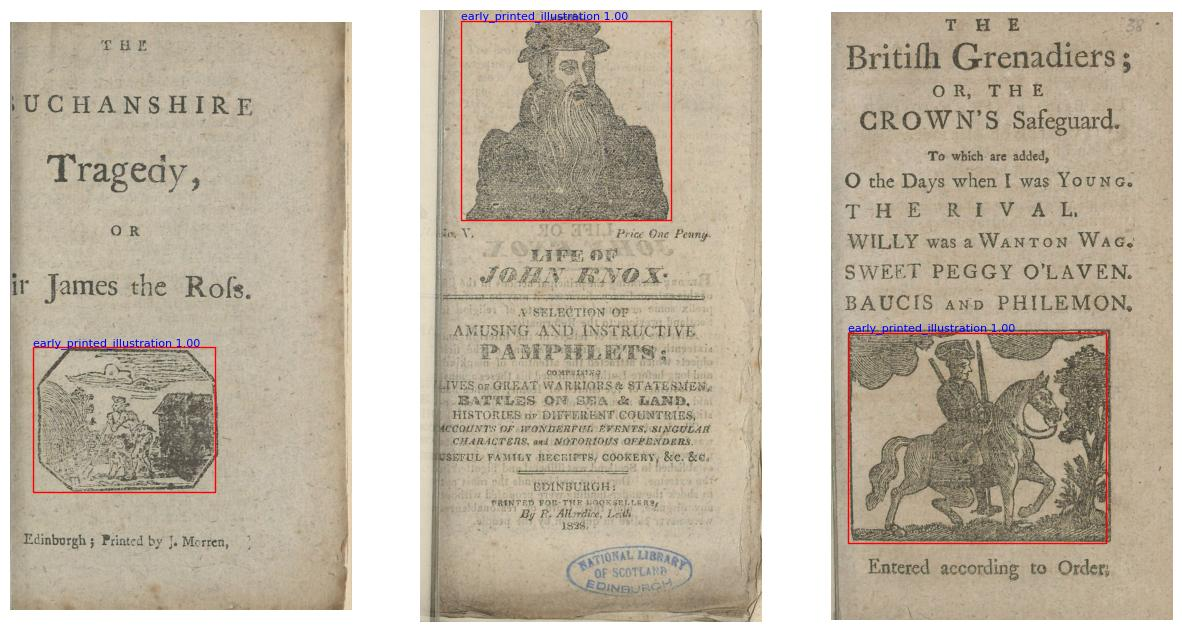

In [ ]:
fig, axs = plt.subplots(1, num_predictions, figsize=(15, 15))
if num_predictions == 1:
    axs = [axs]

itr = iter(dets)
for idx, ax in enumerate(axs):
    ax.imshow(imgs[idx])  # type: ignore
    ax.axis("off")  # type: ignore
    show_dets(ax, next(itr), thresh=0.4, show_labels=True)

### Generate Saliency Maps With `xaitk-saliency` <a name="generate-saliency-maps-with-xaitk-saliency"></a>

#### Prepare Inputs <a name="prepare-inputs"></a>

The `GenerateObjectDetectorBlackboxSaliency` interface requires our reference detections to be split into separate bounding boxes and scores inputs, both as numpy arrays. Here, we convert the detections from our Hugging Face `DetectImageObjects` implementation into an input format usable with xaitk-saliency. However, we note that this is not strictly required as native Hugging Face outputs could have also been correspondingly converted to satisfy `xaitk-saliency` input requirements.

In [ ]:
def dets_to_mats(
    dets: Iterable[tuple[AxisAlignedBoundingBox, dict[Hashable, float]]],
) -> tuple[np.ndarray, np.ndarray]:
    """
    Converts a list of detection results into matrices of bounding boxes and class scores.

    Args:
        dets (List[tuple[Any, dict[Hashable, float]]]): A list of detections, where each detection is a tuple:
            - The first element is a bounding box object with `min_vertex` and `max_vertex` attributes.
            - The second element is a dictionary mapping class labels to confidence scores.

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - bboxes (np.ndarray): A NumPy array of shape `(n, 4)` where `n` is the number of detections.
                Each row represents a bounding box in the format `[x_min, y_min, x_max, y_max]`.
            - scores (np.ndarray): A NumPy array of shape `(n, c)` where `c` is the number of class labels.
                Each row contains the confidence scores for all classes for the corresponding bounding box.
    """
    if not dets:
        return np.empty(0), np.empty(0)

    bboxes = np.empty((0, 4))
    scores = []
    for det in dets:
        bbox = det[0]
        labels = list(det[1].keys())
        bboxes = np.vstack(
            (
                bboxes,
                [
                    *bbox.min_vertex,
                    *bbox.max_vertex,
                ],
            ),
        )

        score_dict = det[1]
        score_array = [score_dict[label] for label in labels]

        scores.append(score_array)

    return bboxes, np.array(scores)

In [ ]:
bboxes = []
scores = []
for det in dets:
    b, s = dets_to_mats(det)
    bboxes.append(b)
    scores.append(s)

#### Saliency Generation Object <a name="saliency-generation-object"></a>

Here we will instantiate our `GenerateObjectDetectorBlackboxSaliency` implementation that combines image pertubation and detector-based saliency map generation into one call.

We will use `DRISEStack` which is comprised of the `RISEGrid` and `DRISEScoring` image pertubation and saliency map generation methods, respectively.

We will also set the saliency generator to use a gray fill to increase saliency map quality. This fill should represent the average channel intensities of the dataset. Here we will estimate it using only our sample images, however the more images included in these calculations the more accurate the estimate would be.

In [ ]:
# Estimate dataset gray average from sampled images
img_arr = np.asarray([np.array(d["image"]) for d in ds_samples], dtype=object)
fill_arr = np.empty((0, 3))
for img in img_arr:
    fill_arr = np.vstack((fill_arr, [np.mean(img, axis=tuple(range(img.ndim - 1)))]))
fill = np.mean(fill_arr, axis=0)  # 179, 167, 145

In [ ]:
sal_generator = DRISEStack(50, 8, 0.5, seed=0, threads=4)
sal_generator.fill = fill

#### Saliency Map Generation <a name="saliency-map-generation"></a>

In [ ]:
sal_maps = []
for idx in range(num_predictions):
    print(f"Generating saliency maps for image {idx + 1} of {num_predictions}...")
    start = time.time()
    sal_maps.append(sal_generator(imgs[idx], bboxes[idx], scores[idx], nls_chapbook_detector))
    end = time.time()
    print(f"Done in {end - start:.2f}s")

Generating saliency maps for image 1 of 3...
Done in 49.84s
Generating saliency maps for image 2 of 3...
Done in 48.09s
Generating saliency maps for image 3 of 3...
Done in 47.49s


#### Saliency Map Visualization <a name="saliency-map-visualization"></a>

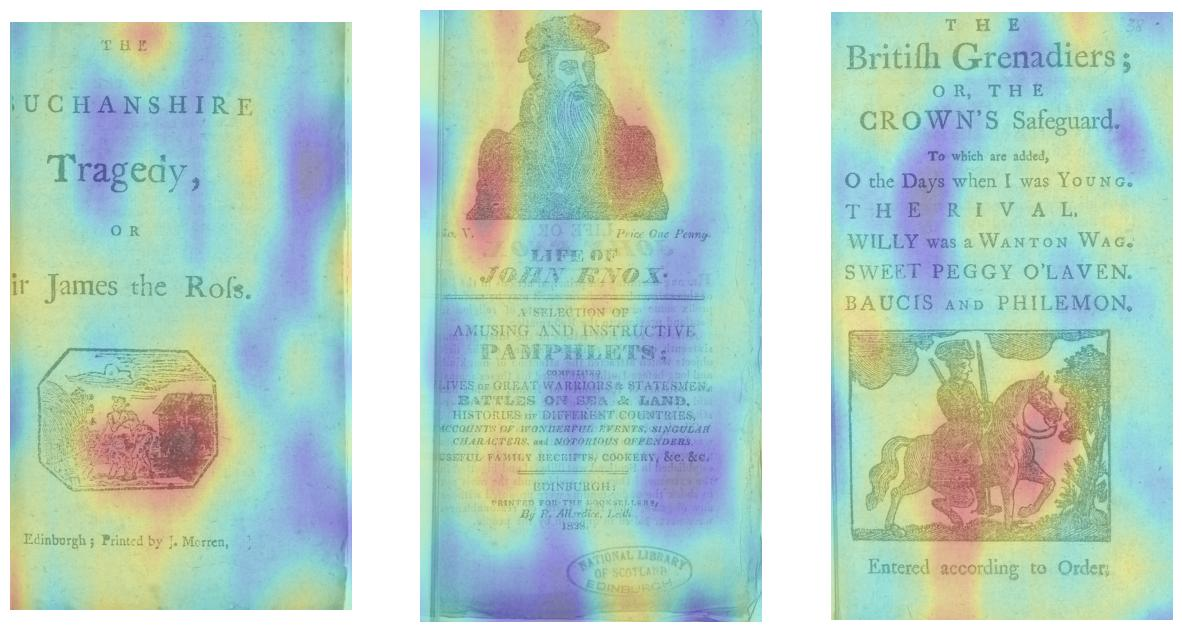

In [ ]:
gray_img = [np.asarray(Image.fromarray(img).convert("L")) for img in imgs]
pad_perc = 0.4

n_rows = max(len(x) for x in sal_maps)
n_cols = len(sal_maps)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15), squeeze=False)

for det_idx in range(n_rows):
    for img_idx in range(n_cols):
        ax = axs[det_idx][img_idx]
        try:
            sal_map = sal_maps[img_idx][det_idx]
        except IndexError:
            ax.axis("off")
            continue

        ax.imshow(gray_img[img_idx], alpha=0.7, cmap="gray")
        ax.imshow(sal_map, alpha=0.3, cmap="jet")
        ax.axis("off")